# Predict Bike Sharing Demand with AutoGluon Template

## Step 1: Download and explore dataset

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle

In [101]:
from kaggle.api.kaggle_api_extended import KaggleApi

import json
kaggle_username = "isabelgomezl"
kaggle_key = "4091489633b596f1c3015660f6da2382"

# Save API token the kaggle.json file
with open("C:/Users/MIGOMLOZ/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [102]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand


  0%|          | 0.00/189k [00:00<?, ?B/s]
100%|##########| 189k/189k [00:00<00:00, 1.27MB/s]
100%|##########| 189k/189k [00:00<00:00, 1.26MB/s]
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [106]:
import zipfile
with zipfile.ZipFile("C:/Users/MIGOMLOZ/Downloads/bike-sharing-demand.zip", 'r') as zip_ref:
    zip_ref.extractall("C:/Users/MIGOMLOZ/Downloads/")

In [67]:
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor

In [107]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [108]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [109]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [110]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 2: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [159]:
train = train.loc[:,(train.columns != 'casual') & (train.columns!= 'registered')]

In [50]:
predictor = TabularPredictor(label="count",problem_type="regression", eval_metric="root_mean_squared_error").fit(
        train_data = train, time_limit = 600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels\ag-20221229_134337\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20221229_134337\"
AutoGluon Version:  0.6.1
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6192.27 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features t

### Review AutoGluon's training run with ranking of models that did the best.

In [60]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.833696      17.617763  353.265994                0.001001           0.638399            3       True         19
1   NeuralNetFastAI_BAG_L2  -52.140190      15.644160  336.657621                0.573045          35.789507            2       True         17
2   RandomForestMSE_BAG_L2  -53.183925      16.116907  314.021495                1.045793          13.153380            2       True         14
3     ExtraTreesMSE_BAG_L2  -53.994802      15.997924  303.684707                0.926809           2.816593            2       True         16
4           XGBoost_BAG_L2  -54.808693      15.266596  310.830415                0.195481           9.962300            2       True         18
5          LightGBM_BAG_L2  -54.962713      15.467416  308.095539         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'Weig

<AxesSubplot:xlabel='model'>

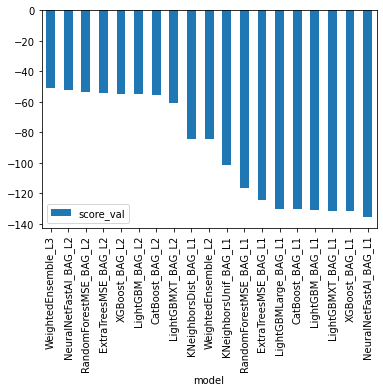

In [61]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

### Create predictions from test dataset

In [69]:
predictions = np.abs(np.rint(predictor.predict(test)))
predictions.head()

0    25.0
1    42.0
2    47.0
3    49.0
4    52.0
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [70]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.321114
std        87.477654
min         1.000000
25%        22.000000
50%        68.000000
75%       167.000000
max       352.000000
Name: count, dtype: float64

In [ ]:
# How many negative values do we have?
#There aren't any

### Set predictions to submission dataframe, save, and submit

In [112]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [113]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/167k [00:00<?, ?B/s]
  5%|4         | 8.00k/167k [00:00<00:02, 77.3kB/s]
100%|##########| 167k/167k [00:00<00:00, 312kB/s]  


### Initial score of 1.76292

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

In [75]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

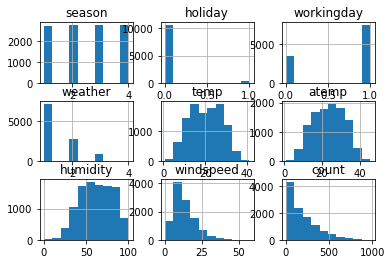

In [74]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [116]:
# create a new feature
train["year"] = pd.DatetimeIndex(train['datetime']).year
train["month"] = pd.DatetimeIndex(train['datetime']).month
train["day"] = pd.DatetimeIndex(train['datetime']).day
train["time"] = pd.DatetimeIndex(train['datetime']).time

test["year"] = pd.DatetimeIndex(test['datetime']).year
test["month"] = pd.DatetimeIndex(test['datetime']).month
test["day"] = pd.DatetimeIndex(test['datetime']).day
test["time"] = pd.DatetimeIndex(test['datetime']).time

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [117]:
for col in ['season', 'weather', 'season', 'weather']:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

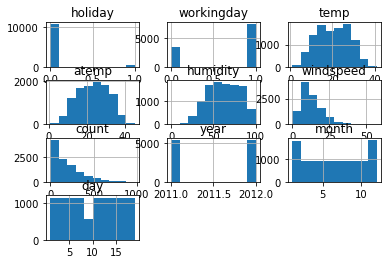

In [89]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [91]:
predictor_new_features = TabularPredictor(label="count",problem_type="regression", eval_metric="root_mean_squared_error").fit(
        train_data = train, time_limit = 600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels\ag-20221229_145007\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20221229_145007\"
AutoGluon Version:  0.6.1
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    6406.18 MB
	Train Data (Original)  Memory Usage: 2.16 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features 

In [92]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.941689      12.358669  476.489505                0.000999           0.516750            3       True         17
1        LightGBMXT_BAG_L2  -30.319567      11.564878  365.182452                1.693594          12.013080            2       True         11
2          LightGBM_BAG_L2  -30.585418      10.253394  362.495708                0.382109           9.326336            2       True         12
3          CatBoost_BAG_L2  -31.249310      10.281966  454.633339                0.410682         101.463967            2       True         14
4     ExtraTreesMSE_BAG_L2  -32.472497      11.182835  359.349027                1.311551           6.179655            2       True         15
5   RandomForestMSE_BAG_L2  -32.669028      10.718195  365.270389         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.548026071

In [118]:
# Remember to set all negative values to zero
predictions_new_features = np.abs(np.rint(predictor_new_features.predict(test)))
predictions_new_features.head()

0    18.0
1    15.0
2    15.0
3    11.0
4     8.0
Name: count, dtype: float32

In [121]:
# Same submitting predictions
submission_new_features = submission
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [122]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/168k [00:00<?, ?B/s]
  5%|4         | 8.00k/168k [00:00<00:02, 80.6kB/s]
100%|##########| 168k/168k [00:00<00:00, 332kB/s]  


### New Score of 0.73705

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [128]:
#import autogluon.core as ag
#from ray import tune

In [154]:
hyperparameter_tune_kwargs = {
    'num_trials': 20,
    'scheduler' : 'local',
    'searcher': 'random',
}

In [179]:
predictor_new_hpo = TabularPredictor(label="count",problem_type="regression", eval_metric="root_mean_squared_error").fit(
        train_data = train,
        time_limit = 600,
        presets="best_quality",
        hyperparameters='light',
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels\ag-20221229_203439\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels\ag-20221229_203439\"
AutoGluon Version:  0.6.1
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19044
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5779.37 MB
	Train Data (Original)  Memory Usage: 2.16 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features 

KeyboardInterrupt: 

In [171]:
predictor_new_hpo = TabularPredictor.load("AutogluonModels/ag-20221229_171628/")

<AxesSubplot:xlabel='model'>

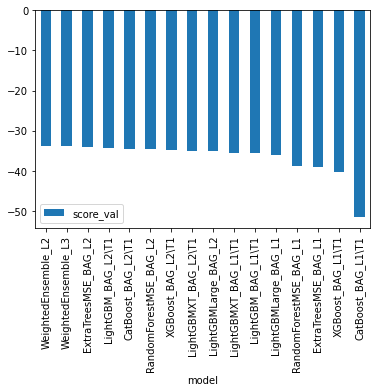

In [172]:
predictor_new_hpo.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [173]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2 -33.840746       3.575966   97.557975                0.000000           0.264866            2       True          8
1      WeightedEnsemble_L3 -33.905180       3.576647  279.406674                0.000000           0.607437            3       True         16
2     ExtraTreesMSE_BAG_L2 -34.063449       3.576504  187.823863                0.000000           4.765702            2       True         13
3       LightGBM_BAG_L2\T1 -34.310830       3.576504  203.733366                0.000000          20.675205            2       True         10
4       CatBoost_BAG_L2\T1 -34.531114       3.576504  218.615270                0.000000          35.557110            2       True         12
5   RandomForestMSE_BAG_L2 -34.553425       3.576504  194.292134                

{'model_types': {'LightGBMXT_BAG_L1\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1\\T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1\\T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1\\T1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2\\T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2\\T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2\\T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L2\\T1': 'StackerEnsembleModel_XGBoost',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1\\T1': -35.45977167893293,
  'LightGBM_BAG_L1\\T1': -35.626973958674014,
  

In [162]:
# Remember to set all negative values to zero
predictor_new_hpo = np.abs(np.rint(predictor_new_hpo.predict(test)))
predictor_new_hpo.head()

0    15.0
1     1.0
2     0.0
3     3.0
4     2.0
Name: count, dtype: float32

In [165]:
# Same submitting predictions
submission_new_hpo = submission
submission_new_hpo["count"] = predictor_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [166]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/168k [00:00<?, ?B/s]
 48%|####7     | 80.0k/168k [00:00<00:00, 710kB/s]
100%|##########| 168k/168k [00:00<00:00, 317kB/s] 


### New Score of  0.50068

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

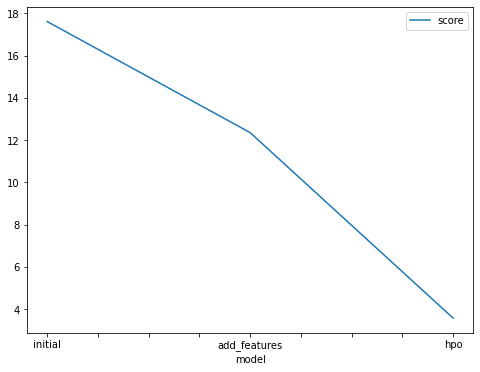

In [176]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [17.617763, 12.358669,  3.575966]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

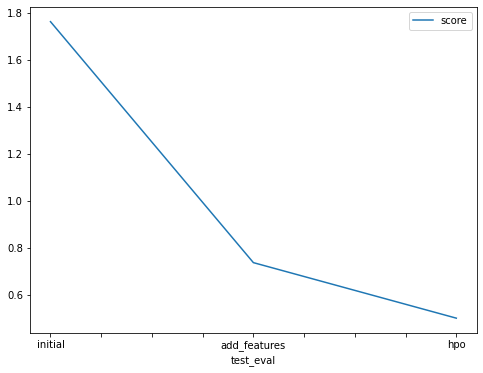

In [177]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.76292, 0.73705, 0.50068]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [178]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1: number or trials": ["NO", "NO", "2'"],
    "hpo2: scheduler": ["NO", "NO", "Local"],
    "hpo3: searcher": ["NO", "NO", "Random"],
    "score": ["1.76292", "0.73705", "0.50068"]
})

,model,hpo1: number or trials,hpo2: scheduler,hpo3: searcher,score
0,initial,NO,NO,NO,1.76292
1,add_features,NO,NO,NO,0.73705
2,hpo,2',Local,Random,0.50068
